# Machine Learning Final Project

## Imports

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import tree, metrics

## Loading Dataset

In [14]:
data_dir = "/kaggle/input/heart-attack-analysis-prediction-dataset"
df = pd.read_csv(f"{data_dir}/heart.csv")

df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [15]:
X = df.loc[:, df.columns != 'output']
Y = df.loc[:,'output']

continuous_df = X[["age", "trtbps", "chol", "thalachh", "oldpeak"]]
categorical_df = X[["sex", "exng", "caa", "cp","fbs", "restecg", "slp", "thall"]]

# Scale continuous columns
scaled_features  = RobustScaler().fit_transform(continuous_df)
continuous_df = pd.DataFrame(scaled_features, index=continuous_df.index, columns=continuous_df.columns)

# One hot encode categorical columns
categorical_df = pd.get_dummies(categorical_df, columns=categorical_df.columns, dtype='int')

X = pd.concat([continuous_df, categorical_df], axis=1)

# 80 - 20 split
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=42)

## Exploratory Data Analysis

### Feature Correlations

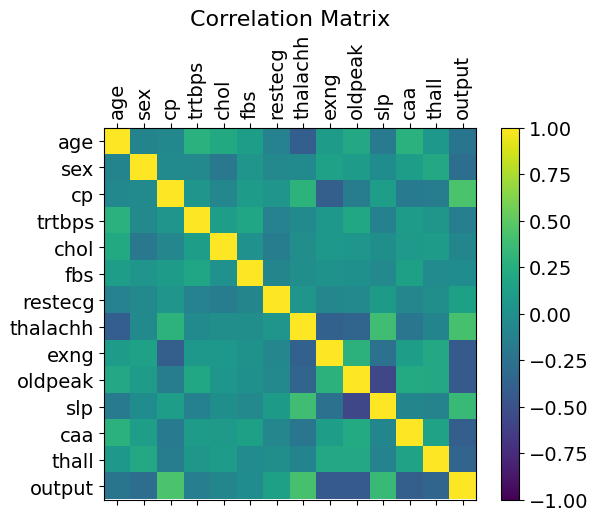

In [16]:
f = plt.figure()
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
plt.clim(-1,1)
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### PCA Analysis

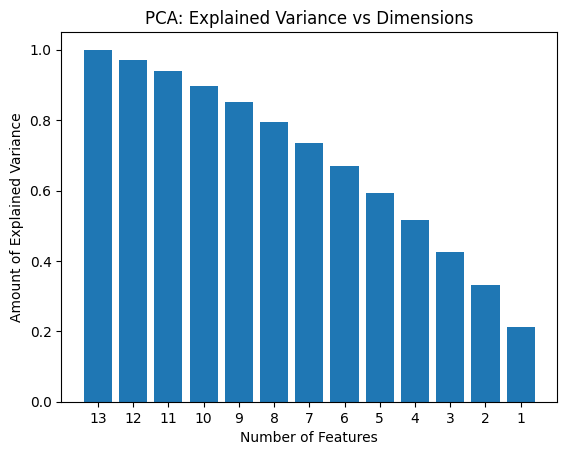

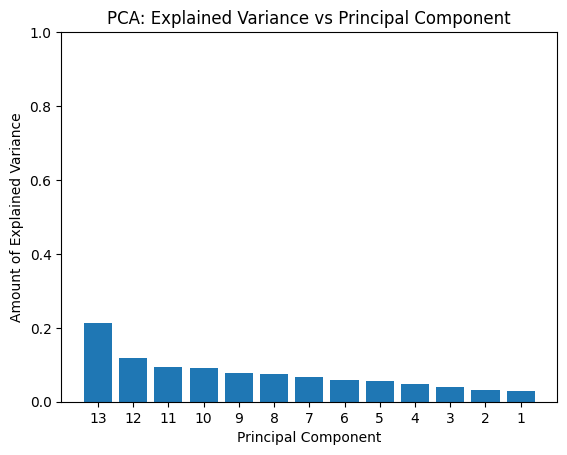

In [17]:
# normalize data before PCA

x = df.loc[:, df.columns != 'output'].values
y = df.loc[:,['output']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=13)
principals = pca.fit_transform(x)
principal_df = pd.DataFrame(data = principals)

reduced_df = pd.concat([principal_df, df[['output']]], axis = 1)

x = np.array([i for i in range(13, 0, -1)])
y = np.array([sum(pca.explained_variance_ratio_[0:i]) for i in range(13, 0, -1)])

plt.title("PCA: Explained Variance vs Dimensions")
plt.xlabel("Number of Features")
plt.ylabel("Amount of Explained Variance")
plt.bar(range(len(x)),y)
plt.xticks(range(len(x)),x)
plt.show()

x = np.array([i for i in range(13, 0, -1)])
y = pca.explained_variance_ratio_

plt.title("PCA: Explained Variance vs Principal Component")
plt.xlabel("Principal Component")
plt.ylabel("Amount of Explained Variance")
plt.ylim(0,1)
plt.bar(range(len(x)),y)
plt.xticks(range(len(x)),x)
plt.show()

In [18]:
def display_model_statistics(model, X, Y, title):
    y_pred = model.predict(X)
    confusion = metrics.confusion_matrix(Y, y_pred)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion) #display_labels=["good heart", "bad heart"]
    disp.plot()
    disp.ax_.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    disp.ax_.xaxis.set_label_position('top') # <-- This doesn't work!
    plt.title(title)
    plt.show()

    tn, fp, fn, tp = confusion.ravel()
    print("F-score:", metrics.f1_score(Y, y_pred, average="micro"))
    print("Accuracy:", (tp+tn) / (tp+tn+fn+fp))
    print("Precision:", tp / (tp+fp))
    print("Sensitivity:", tp / (tp+fn))
    print("Specificity:", tn / (tn+fp))
    

In [19]:
tree_search = {
    'criterion': ['gini'],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 15, None],
    'min_samples_split': [0.15, 0.2, 2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid_search = GridSearchCV(
    estimator = tree.DecisionTreeClassifier(),
    param_grid = tree_search, 
    cv = 3, verbose=1, n_jobs = -1
)

dt_grid_search.fit(train_X, train_Y)
tree_params = dt_grid_search.best_params_

print("Best parameters for random forest:")
print(tree_params)

Fitting 3 folds for each of 135 candidates, totalling 405 fits
Best parameters for random forest:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2}


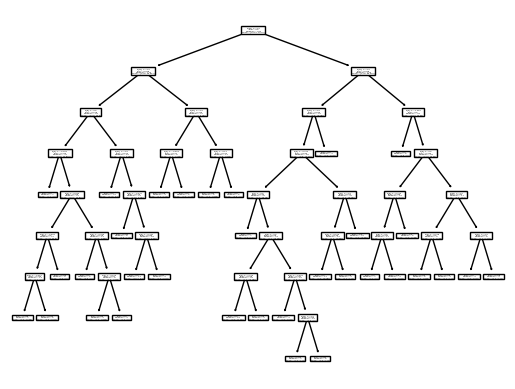

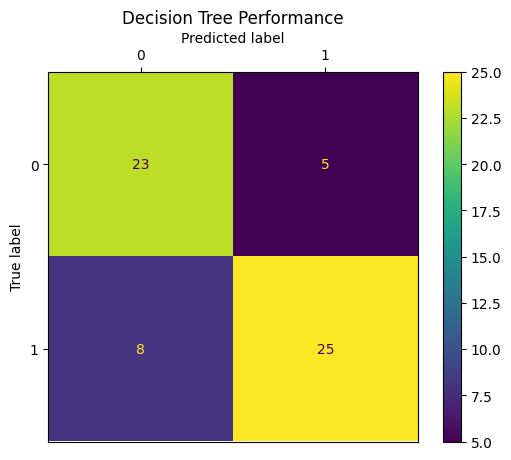

F-score: 0.7868852459016392
Accuracy: 0.7868852459016393
Precision: 0.8333333333333334
Sensitivity: 0.7575757575757576
Specificity: 0.8214285714285714


In [20]:
best_dt = tree.DecisionTreeClassifier(
    criterion=tree_params["criterion"],
    max_depth=tree_params["max_depth"],
    min_samples_split=tree_params["min_samples_split"],
    min_samples_leaf=tree_params["min_samples_leaf"],
    max_features=tree_params["max_features"],
    class_weight="balanced",
    random_state=42
)
best_dt.fit(train_X, train_Y)

tree.plot_tree(best_dt)
display_model_statistics(best_dt, test_X, test_Y, "Decision Tree Performance")

In [21]:
# random_grid = {
#     'criterion': ['gini'],
#     'bootstrap': [True, False],
#     'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
#     'max_features': ['log2', 'sqrt', None],
#     'max_depth': [int(x) for x in np.linspace(10, 50, num = 11)],
#     'min_samples_split': [0.1, 0.15, 0.2, 5, 10],
#     'min_samples_leaf': [1, 2, 4, 8]
# }

# rf_rand_search = RandomizedSearchCV(
#     estimator = RandomForestClassifier(), 
#     param_distributions = random_grid, 
#     n_iter = 100, cv = 3, verbose=1, random_state=42, n_jobs = -1
# )

# rf_rand_search.fit(train_X, train_Y)

# print("Best parameters in random search:")
# print(rf_rand_search.best_params_)
# {'n_estimators': 1000, 'min_samples_split': 0.15, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 14, 'criterion': 'gini', 'bootstrap': True}

In [22]:
narrowed_grid = {
    'criterion': ['gini'],
    'bootstrap': [True],
    'n_estimators': [200, 500, 1000],
    'max_features': ['sqrt'],
    'max_depth': [4, 8, None],
    'min_samples_split': [0.1, 0.15, 0.2],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(
    estimator = RandomForestClassifier(),
    param_grid = narrowed_grid, 
    cv = 3, verbose=1, n_jobs = -1
)

rf_grid_search.fit(train_X, train_Y)
rf_params = rf_grid_search.best_params_

print("Best parameters for random forest:")
print(rf_params)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for random forest:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 0.2, 'n_estimators': 500}


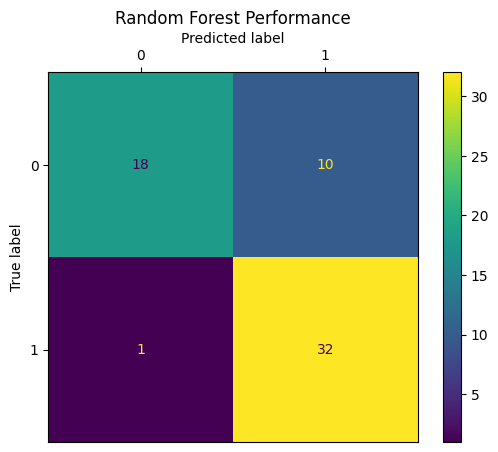

F-score: 0.819672131147541
Accuracy: 0.819672131147541
Precision: 0.7619047619047619
Sensitivity: 0.9696969696969697
Specificity: 0.6428571428571429


In [23]:
rf_params = {'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 0.1, 'n_estimators': 500}

best_rf = RandomForestClassifier(
    bootstrap=rf_params["bootstrap"],
    n_estimators=rf_params["n_estimators"], 
    criterion=rf_params["criterion"],
    max_depth=rf_params["max_depth"],
    min_samples_split=rf_params["min_samples_split"],
    min_samples_leaf=rf_params["min_samples_leaf"],
    max_features=rf_params["max_features"],
    n_jobs=-1,
    random_state=42
)

best_rf = best_rf.fit(train_X, train_Y)
display_model_statistics(best_rf, test_X, test_Y, "Random Forest Performance")

In [24]:
logreg_params = {
    # compatible with all solvers
#     "penalty": [None, "l1", "l2", "elasticnet"],
    "C": [1.0, 0.5, 0.25],
    "solver": ["lbfgs", "liblinear"],
    "max_iter": [10000],
}

logreg_search = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid = logreg_params,
    cv = 3,
    verbose = 1,
    n_jobs = -1
)

logreg_search.fit(train_X, train_Y)
best_logreg_params = logreg_search.best_params_

print("Best parameters for logreg:")
print(best_logreg_params)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for logreg:
{'C': 0.5, 'max_iter': 10000, 'solver': 'lbfgs'}


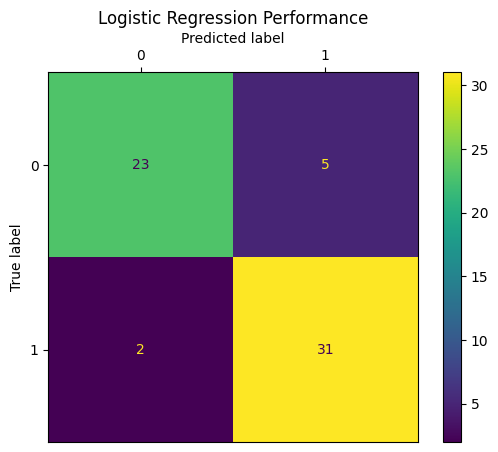

F-score: 0.8852459016393442
Accuracy: 0.8852459016393442
Precision: 0.8611111111111112
Sensitivity: 0.9393939393939394
Specificity: 0.8214285714285714


In [25]:
# best_logreg_params = {'C': 1, 'max_iter': 10000, 'solver': 'liblinear'}

best_lr = LogisticRegression(
    C=best_logreg_params["C"], 
    max_iter=best_logreg_params["max_iter"],
    solver=best_logreg_params["solver"],
    random_state=42
)

best_lr.fit(train_X, train_Y)

display_model_statistics(best_lr, test_X, test_Y, "Logistic Regression Performance")

In [26]:
svm_params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": [1, 2, 3, 5],
    "tol": [1e-4, 1e-2, 1, 10],
    "decision_function_shape": ["ovo"],
    "max_iter": [10000],
}

svm_search = GridSearchCV(
    estimator = SVC(),
    param_grid = svm_params,
    cv = 3,
    verbose = 1,
    n_jobs = -1
)

svm_search.fit(train_X, train_Y)
best_svm_params = svm_search.best_params_

print("Best parameters for SVM:")
print(best_svm_params)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best parameters for SVM:
{'decision_function_shape': 'ovo', 'degree': 1, 'kernel': 'poly', 'max_iter': 10000, 'tol': 1}


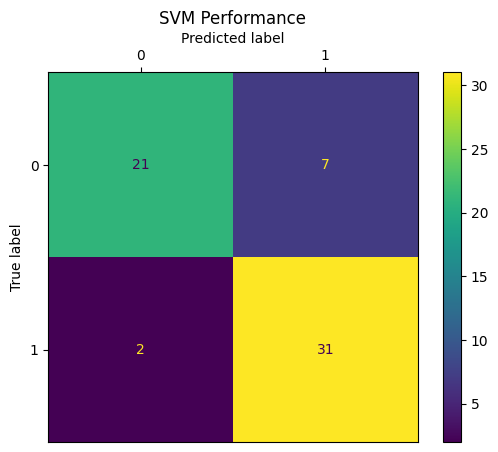

F-score: 0.8524590163934426
Accuracy: 0.8524590163934426
Precision: 0.8157894736842105
Sensitivity: 0.9393939393939394
Specificity: 0.75


In [27]:
# best_svm_params = {'decision_function_shape': 'ovo', 'degree': 1, 'kernel': 'sigmoid', 'max_iter': 10000, 'tol': 0.0001}

best_svm = SVC(
    decision_function_shape=best_svm_params["decision_function_shape"], 
    degree=best_svm_params["degree"],
    kernel=best_svm_params["kernel"],
    max_iter=best_svm_params["max_iter"],
    tol=best_svm_params["tol"],
    random_state=42
)

best_svm.fit(train_X, train_Y)

display_model_statistics(best_svm, test_X, test_Y, "SVM Performance")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best paramters for mlp: {'activation': 'identity', 'hidden_layer_sizes': array([10]), 'max_iter': 10000, 'solver': 'lbfgs'}


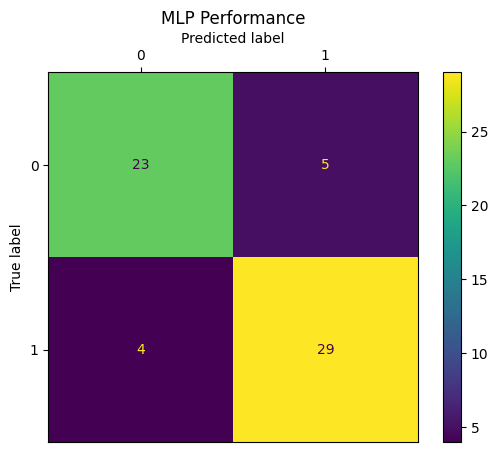

F-score: 0.8524590163934426
Accuracy: 0.8524590163934426
Precision: 0.8529411764705882
Sensitivity: 0.8787878787878788
Specificity: 0.8214285714285714


In [28]:
mlp_params = {
    "activation": ["identity", "logistic", "tanh", "relu"],
    "solver": ["lbfgs"], # our data set is pretty small
    "hidden_layer_sizes": [
        np.array([10]),
        np.array([50]),
        np.array([100]),
        np.array([500]),
        np.array([1000]),
        np.array([100, 100]),
        np.array([50, 50, 50]),
        np.array([100, 100, 100]),
    ],
    "max_iter": [10000],
}

mlp_search = GridSearchCV(
    estimator = MLPClassifier(),
    param_grid = mlp_params,
    cv = 3,
    verbose = 1,
    n_jobs = -1
)

mlp_search.fit(train_X, train_Y)
print("Best paramters for mlp:", mlp_search.best_params_)
mlp_best = mlp_search.best_estimator_
display_model_statistics(mlp_best, test_X, test_Y, "MLP Performance")

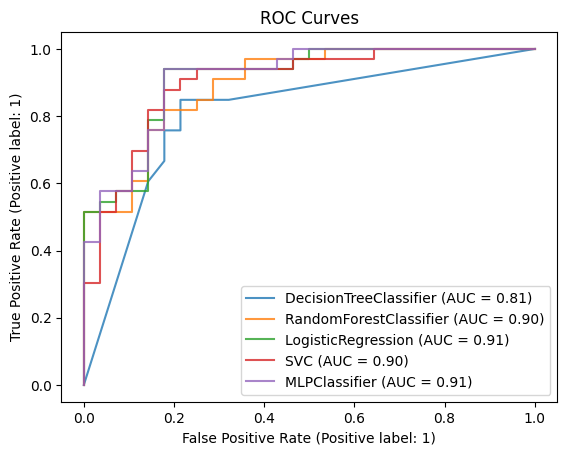

In [29]:
classifiers = [best_dt, best_rf, best_lr, best_svm, mlp_best]

ax = plt.gca()

for classifier in classifiers:
    metrics.RocCurveDisplay.from_estimator(classifier, test_X, test_Y, ax=ax, alpha=0.8)

plt.title("ROC Curves")
plt.show()